In [ ]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from settings import RAW_PATH
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import category_encoders as ce
from pandas import Series
from pandas import DataFrame
import ast
from typing import Dict, List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from settings import DATA_PATH

In [ ]:
df = pd.read_csv(RAW_PATH / "train.csv", index_col= 0, parse_dates=['publish_date'])
df.sort_values('publish_date', inplace=True)
df.head()

In [ ]:
df = df[df['views'] <= 1_000_000]
df = df[df['depth'] < 1.79]
df.loc[df['full_reads_percent'] > 100, 'full_reads_percent'] = np.nan
df['full_reads_percent'].fillna((df['full_reads_percent'].mean()), inplace=True)

df = df[df.category.isin(
    ['5409f11ce063da9c8b588a18', '5409f11ce063da9c8b588a12', '5433e5decbb20f277b20eca9', '540d5ecacbb20f2524fc050a',
     '540d5eafcbb20f2524fc0509', '5409f11ce063da9c8b588a13'])]

In [ ]:
df['Time'] = np.arange(len(df.index))
df.head()

In [ ]:
df=df[df['views']<1_000_000]

In [ ]:
cats=df.category.unique()

In [ ]:
def show_timeline(data, col, cat):
    plt.style.use("seaborn-whitegrid")
    plt.rc(
        "figure",
        autolayout=True,
        figsize=(11, 4),
        titlesize=18,
        titleweight='bold',
    )
    plt.rc(
        "axes",
        labelweight="bold",
        labelsize="large",
        titleweight="bold",
        titlesize=16,
        titlepad=10,
    )
    %config InlineBackend.figure_format = 'retina'

    fig, ax = plt.subplots()
    ax.plot('Time', col, data=data, color='0.75')
    ax.set_title(cat)
    ax = sns.regplot(x='Time', y=col, data=data, ci=None, scatter_kws=dict(color='0.25'))

In [ ]:
for col in ['views', 'depth', 'full_reads_percent']:
    for cat in cats:
        d = df[df['category'] == cat]
        show_timeline(d, col, cat)

In [ ]:
df.to_csv(DATA_PATH/'time.csv')

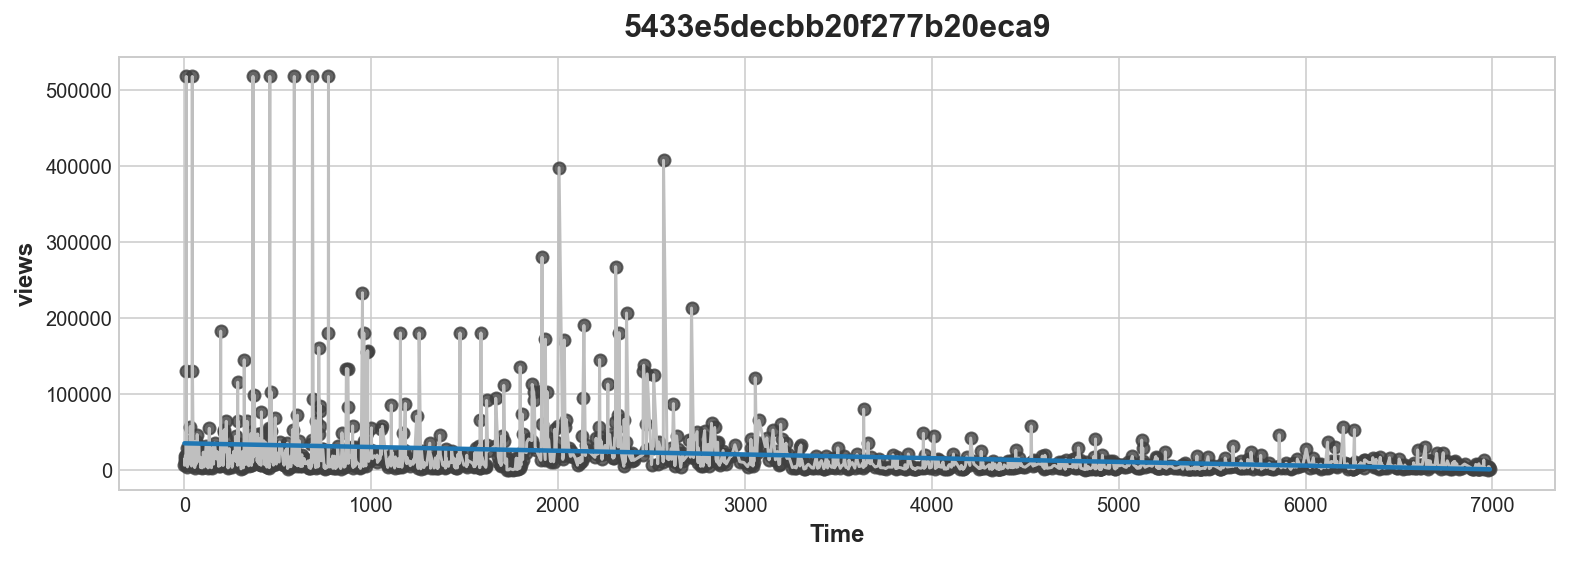

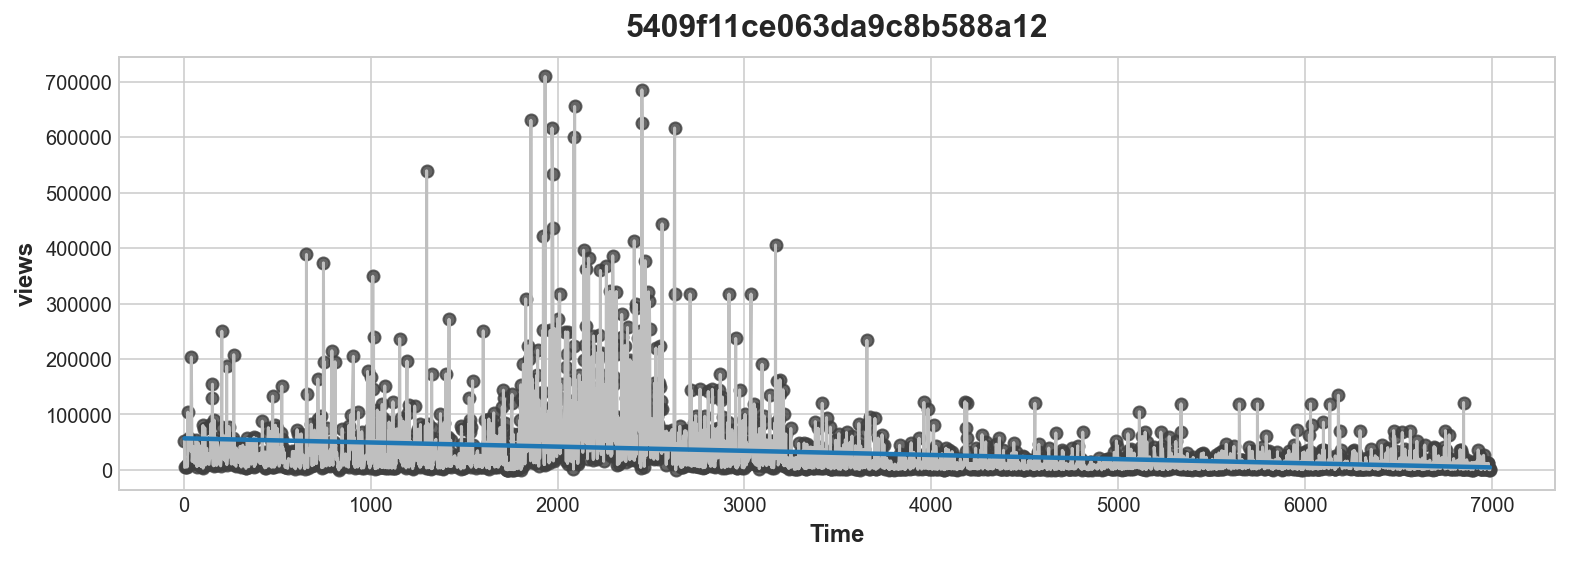

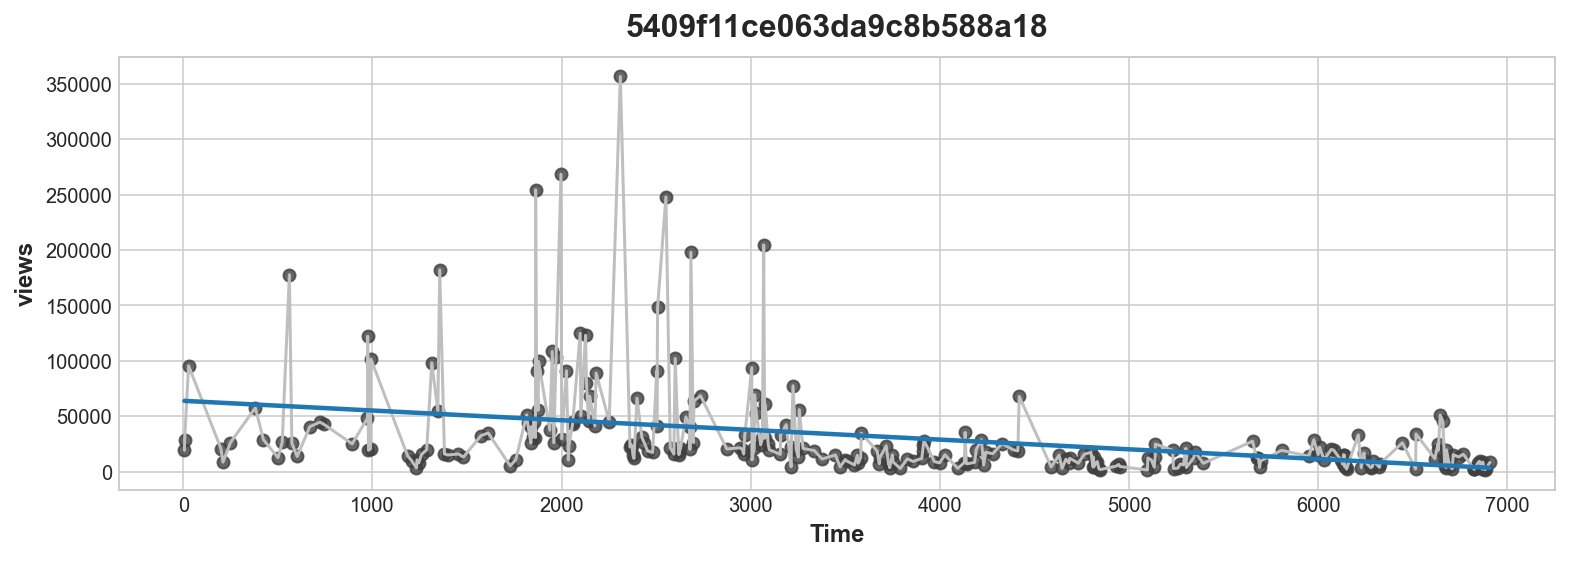

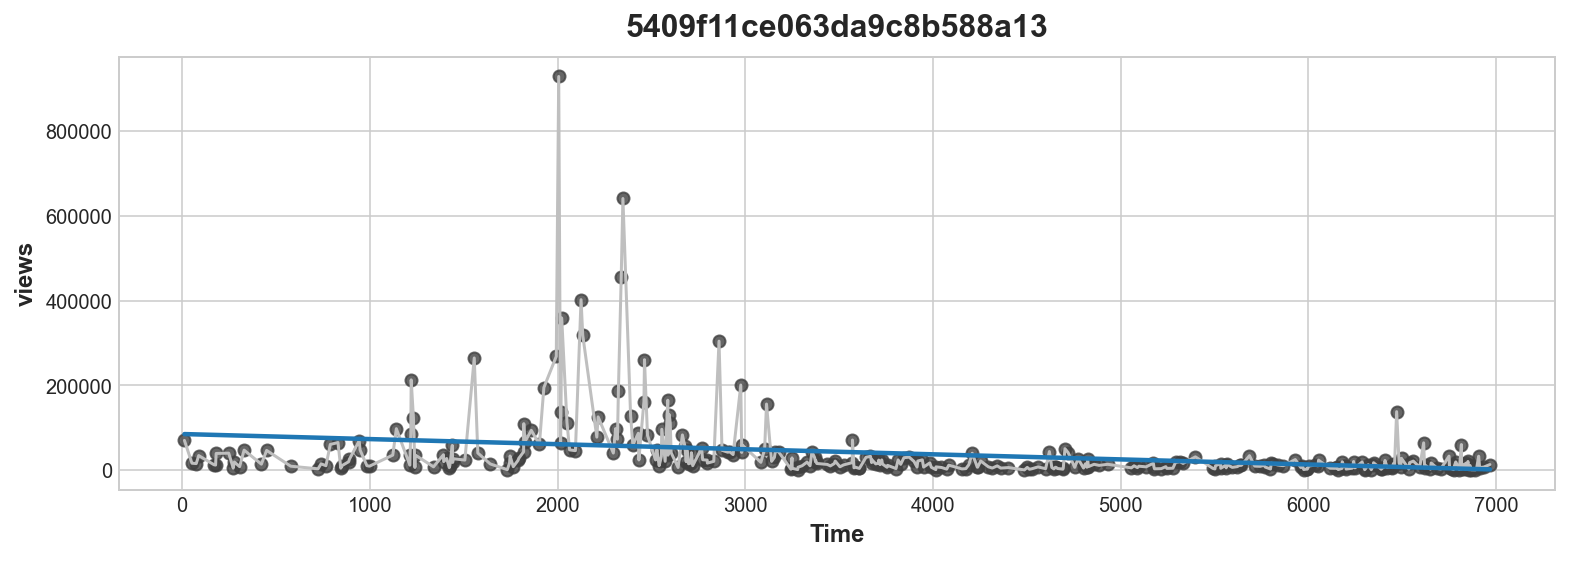

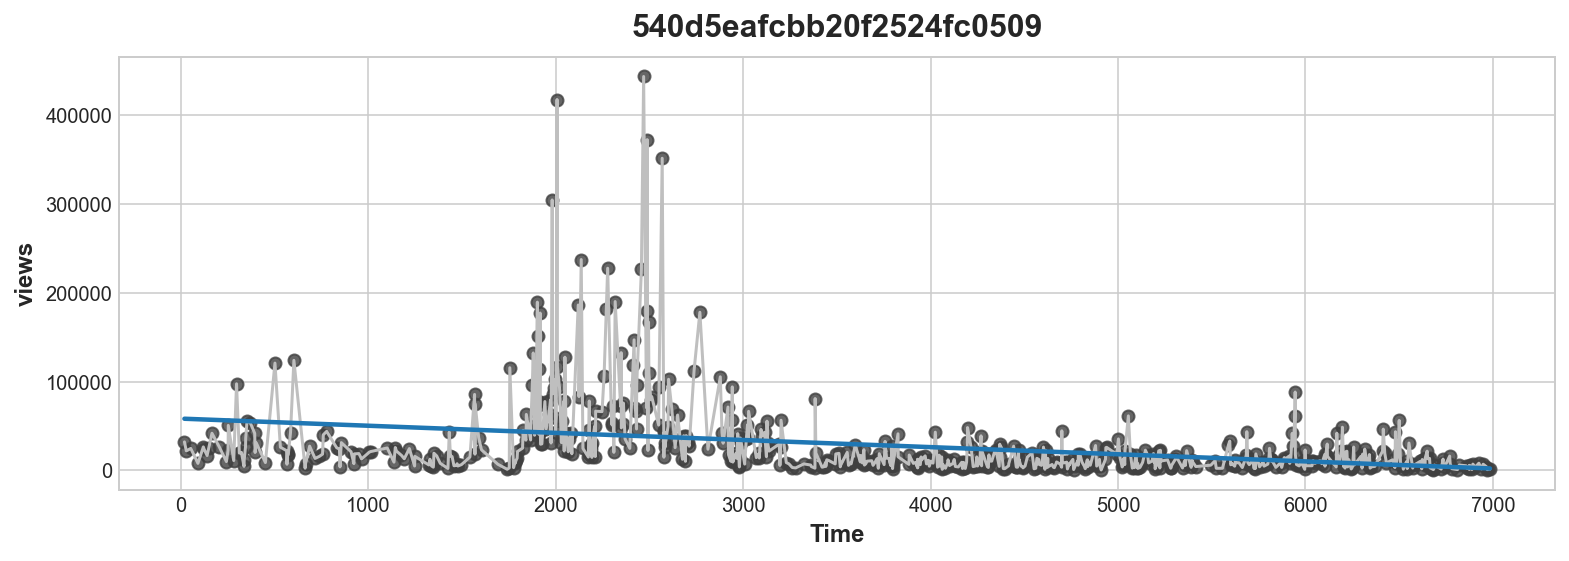

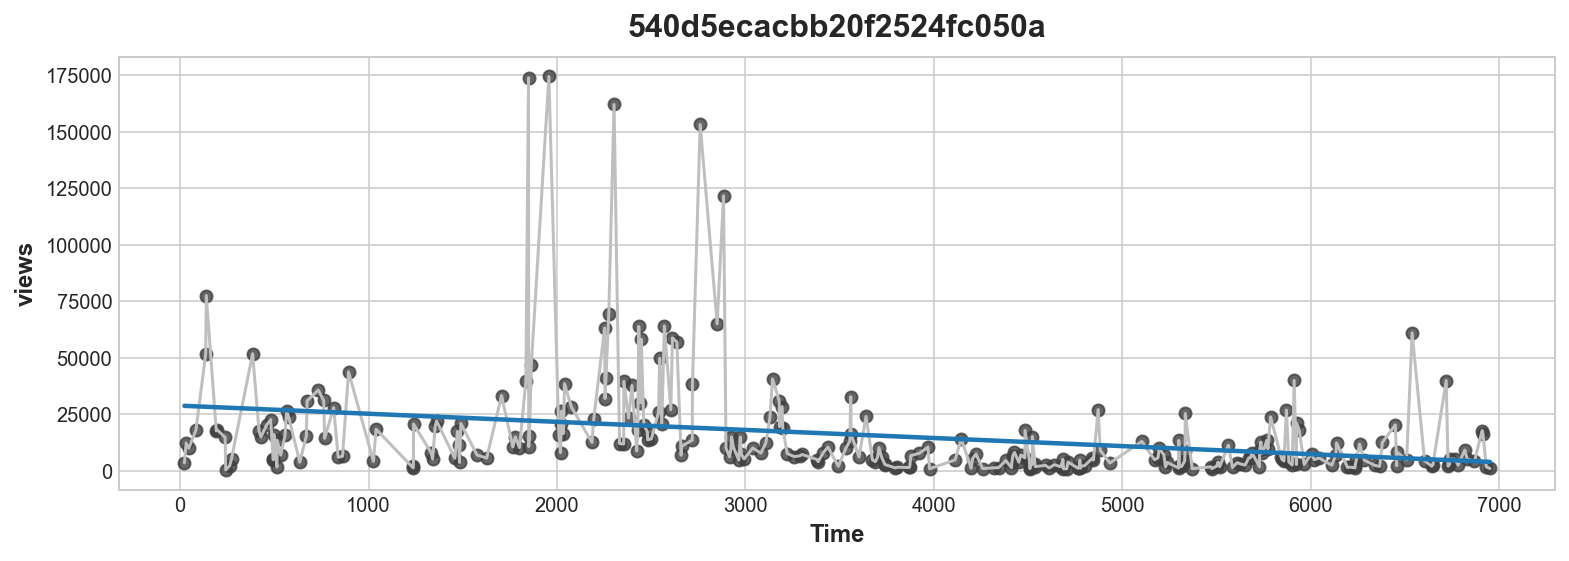

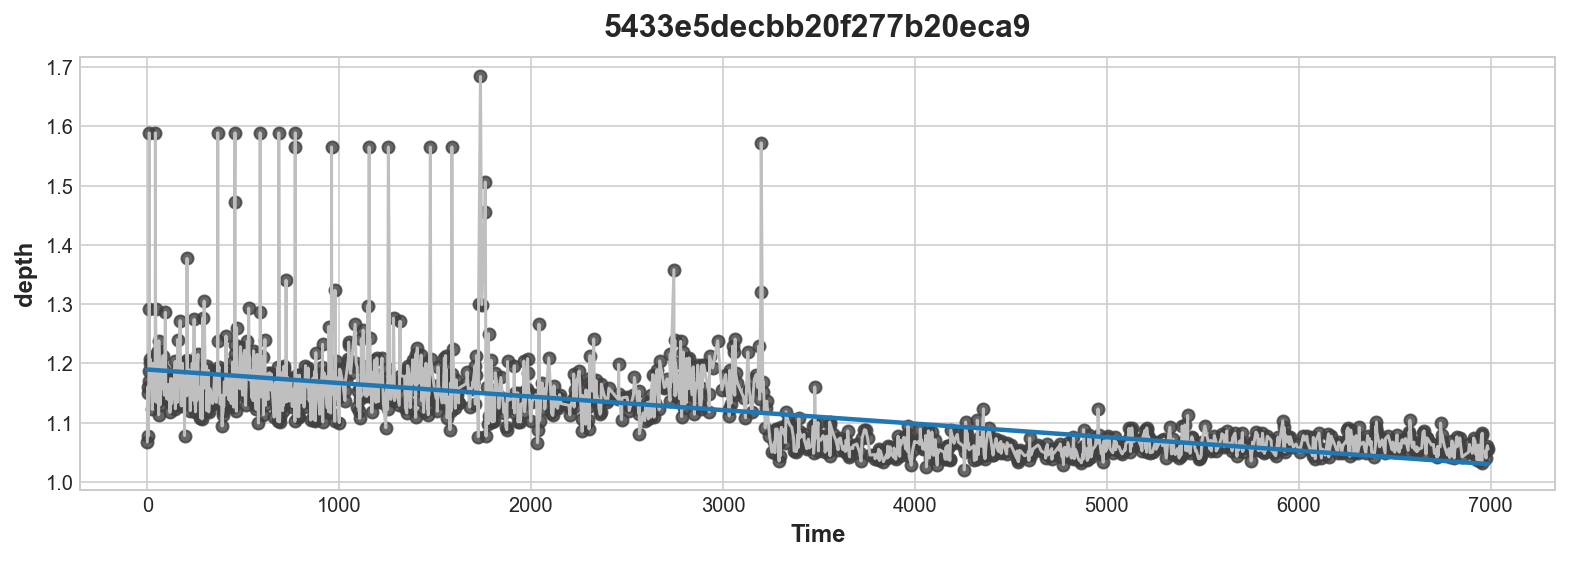

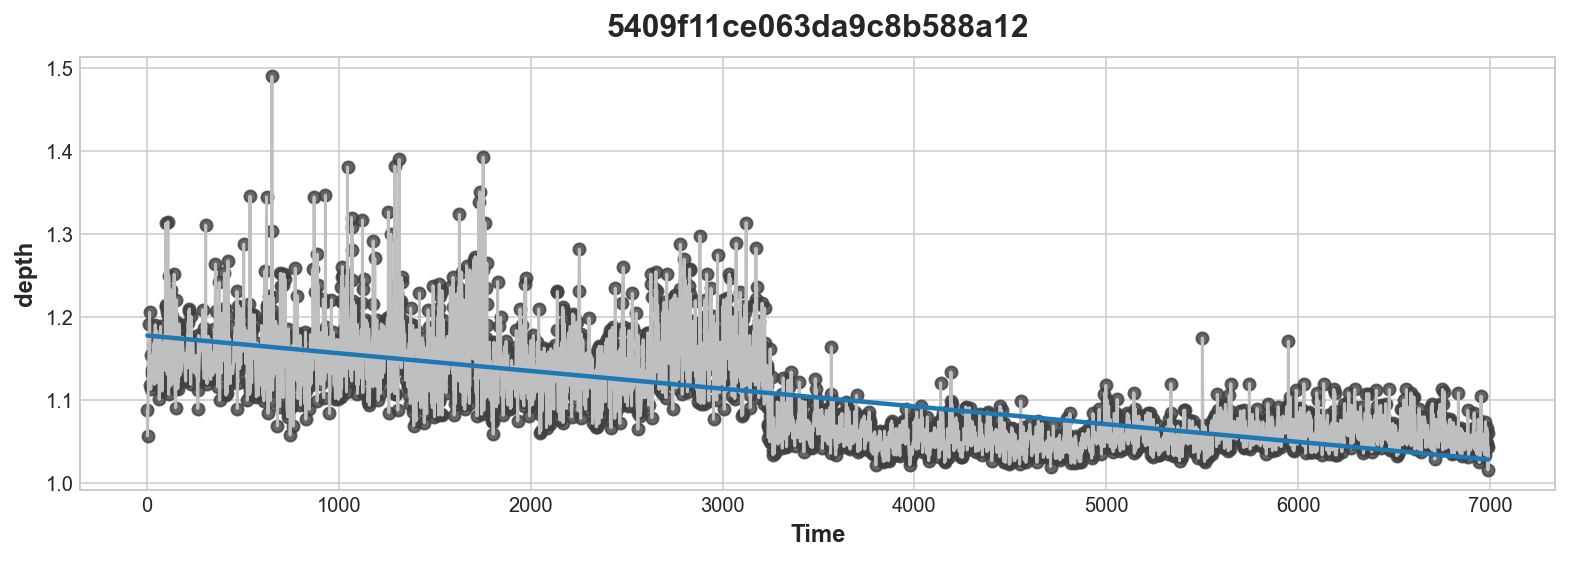

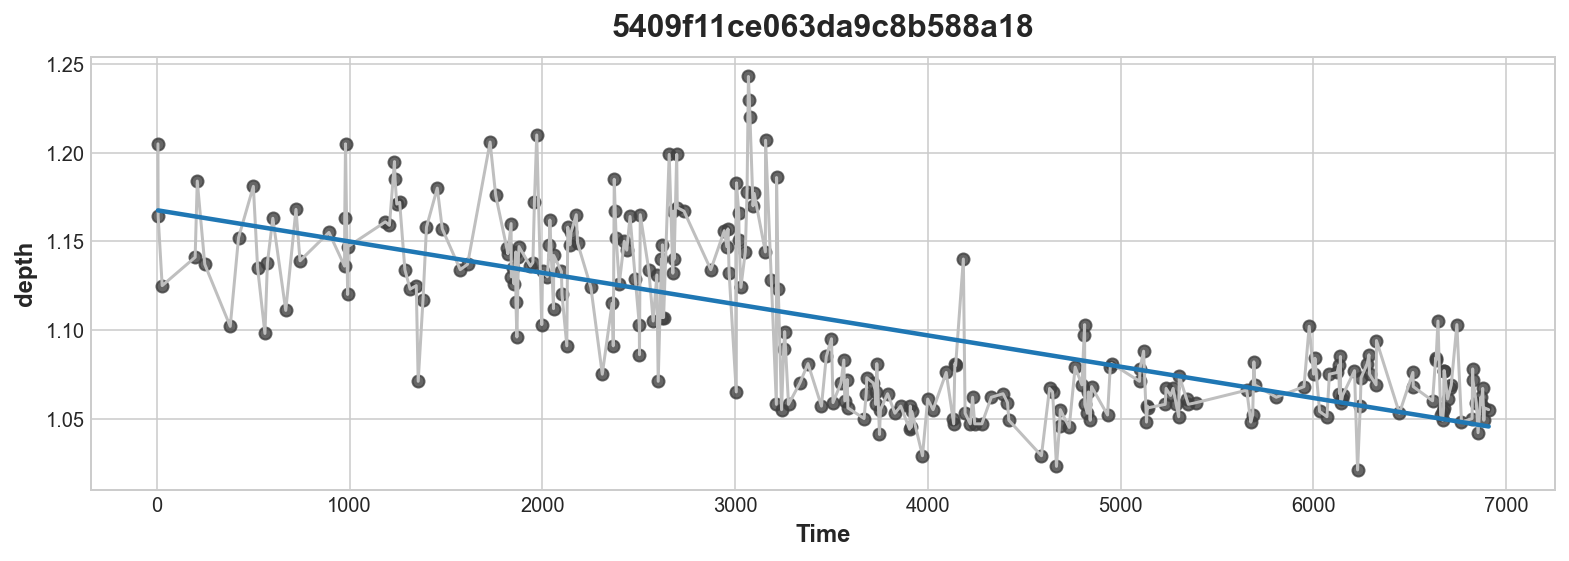

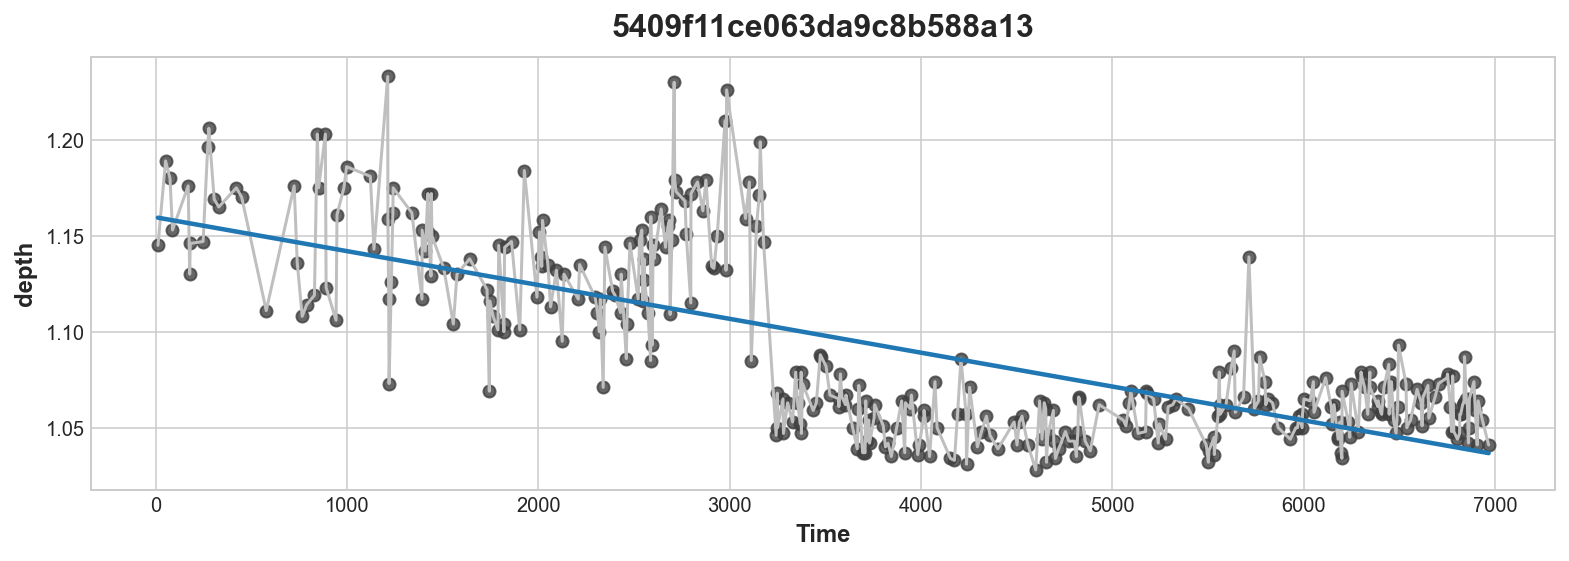

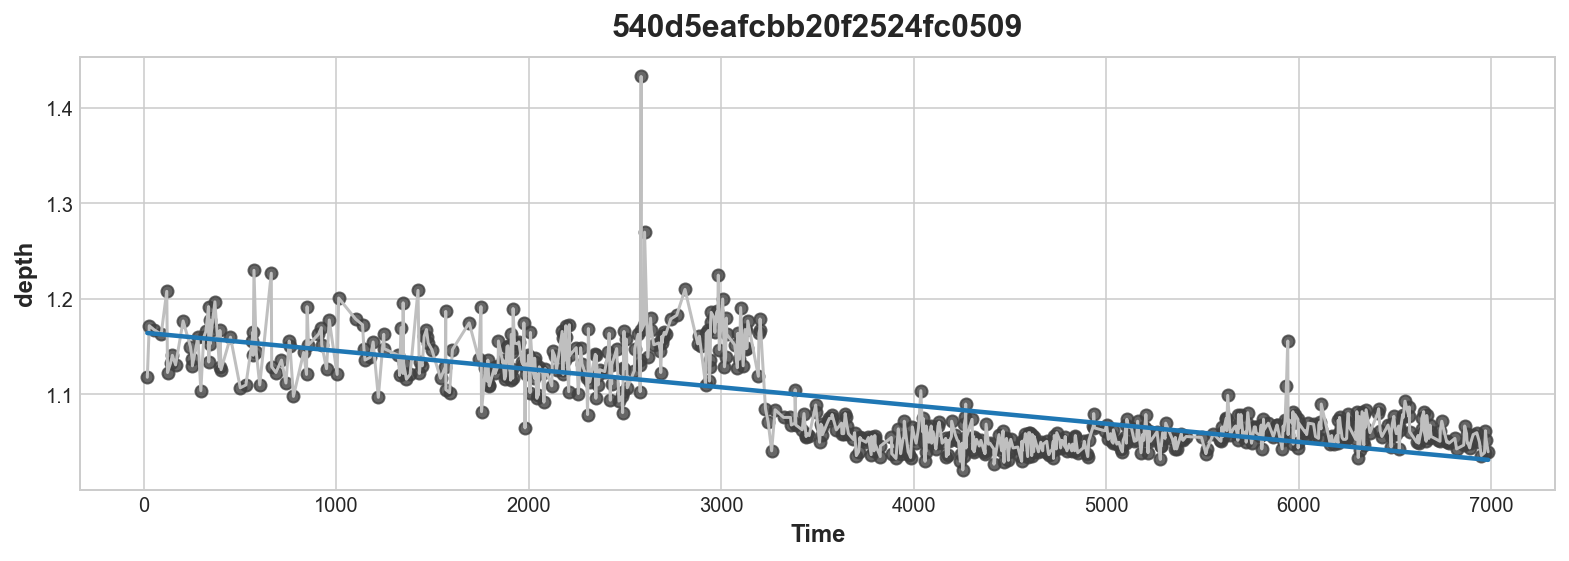

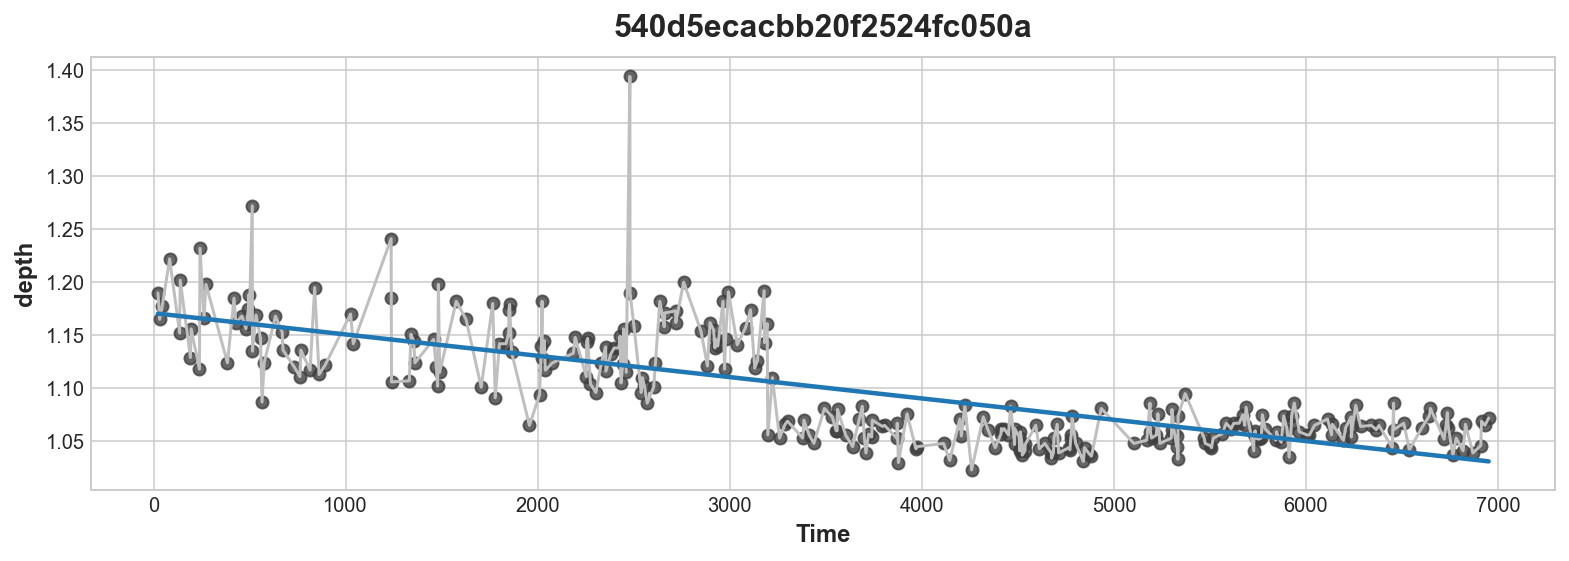

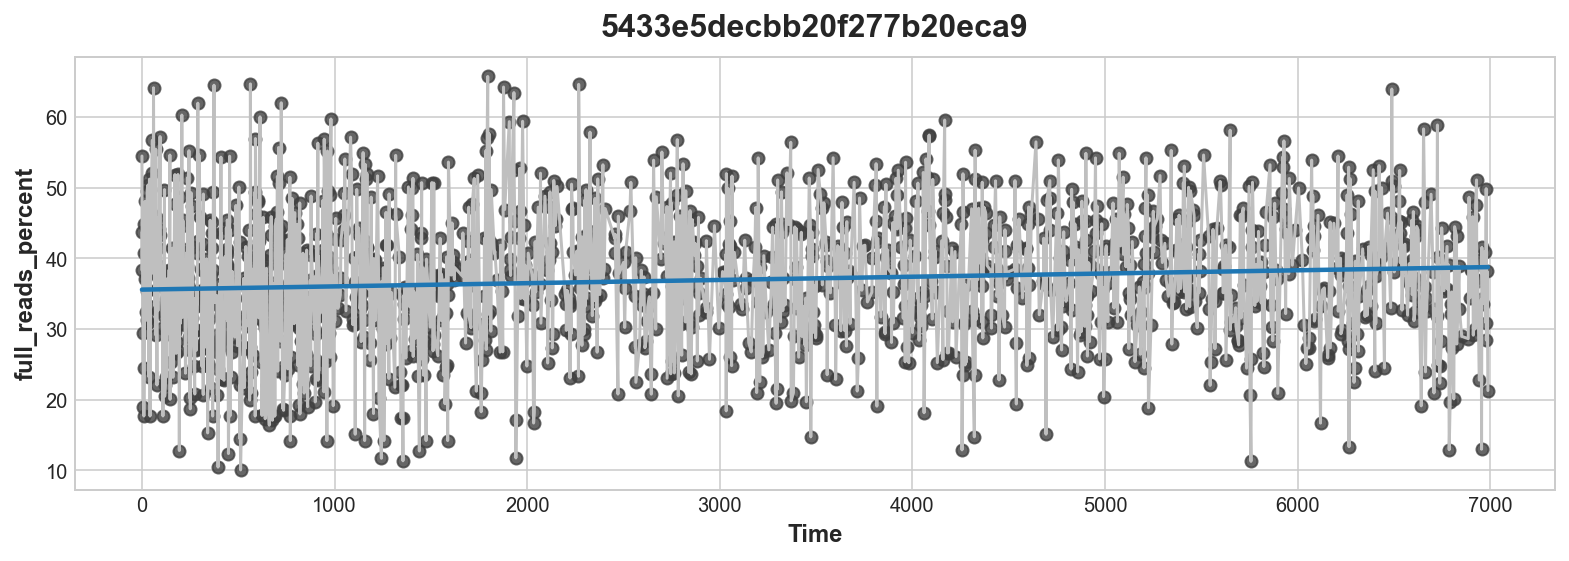

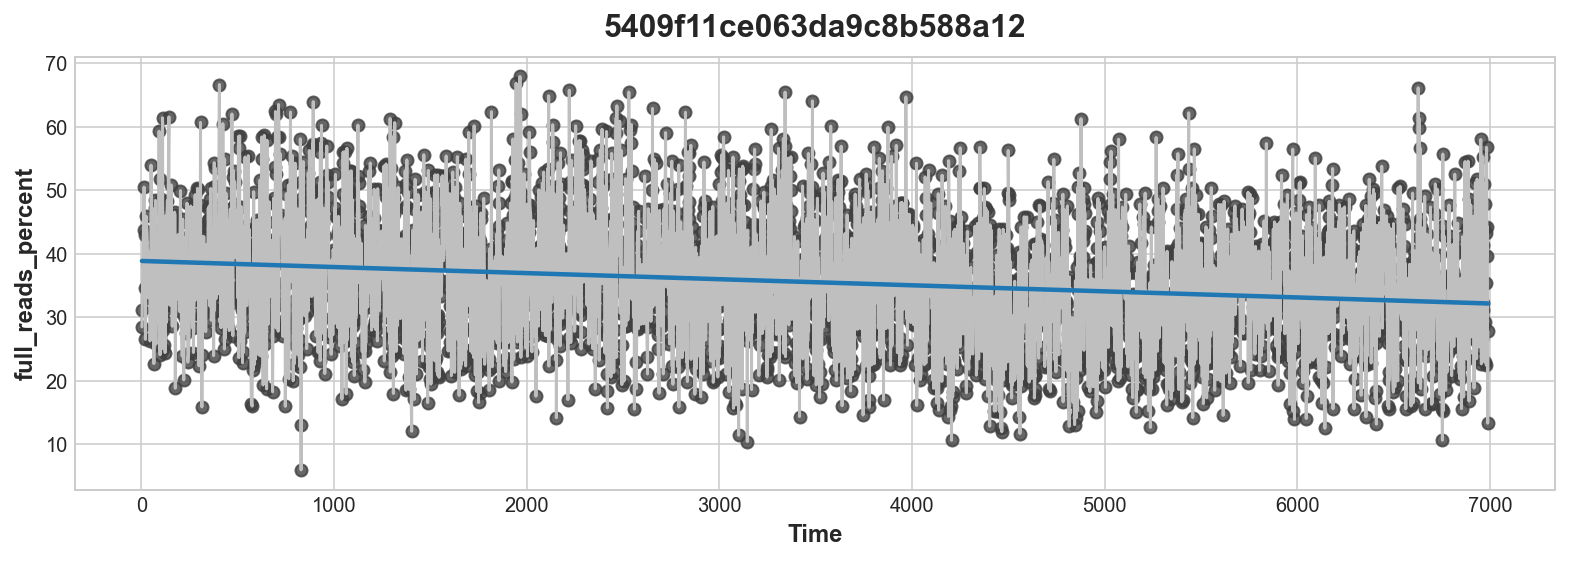

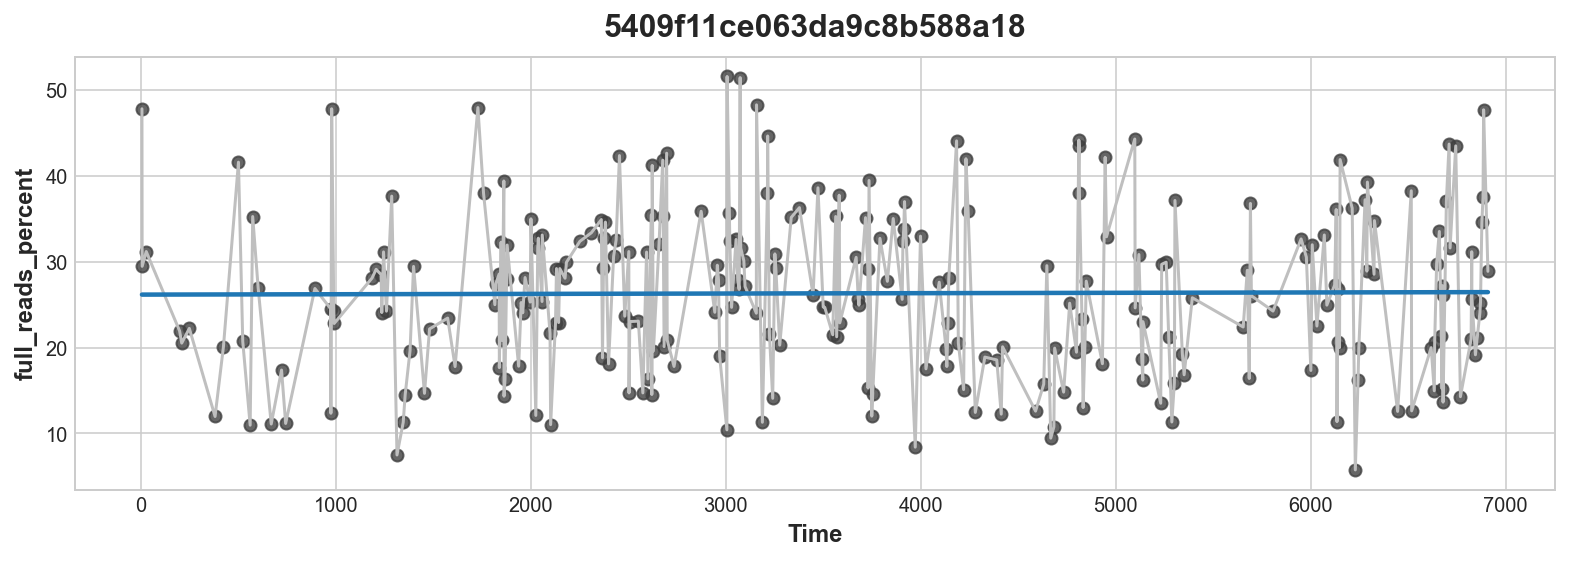

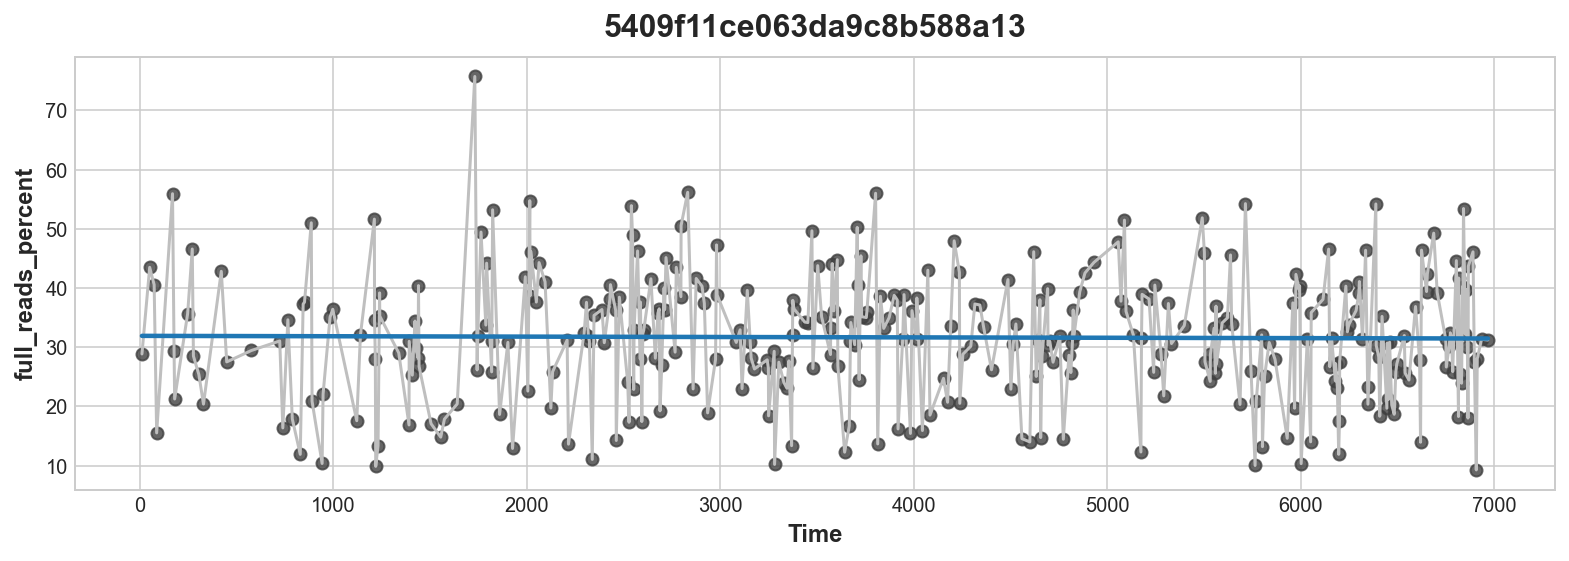

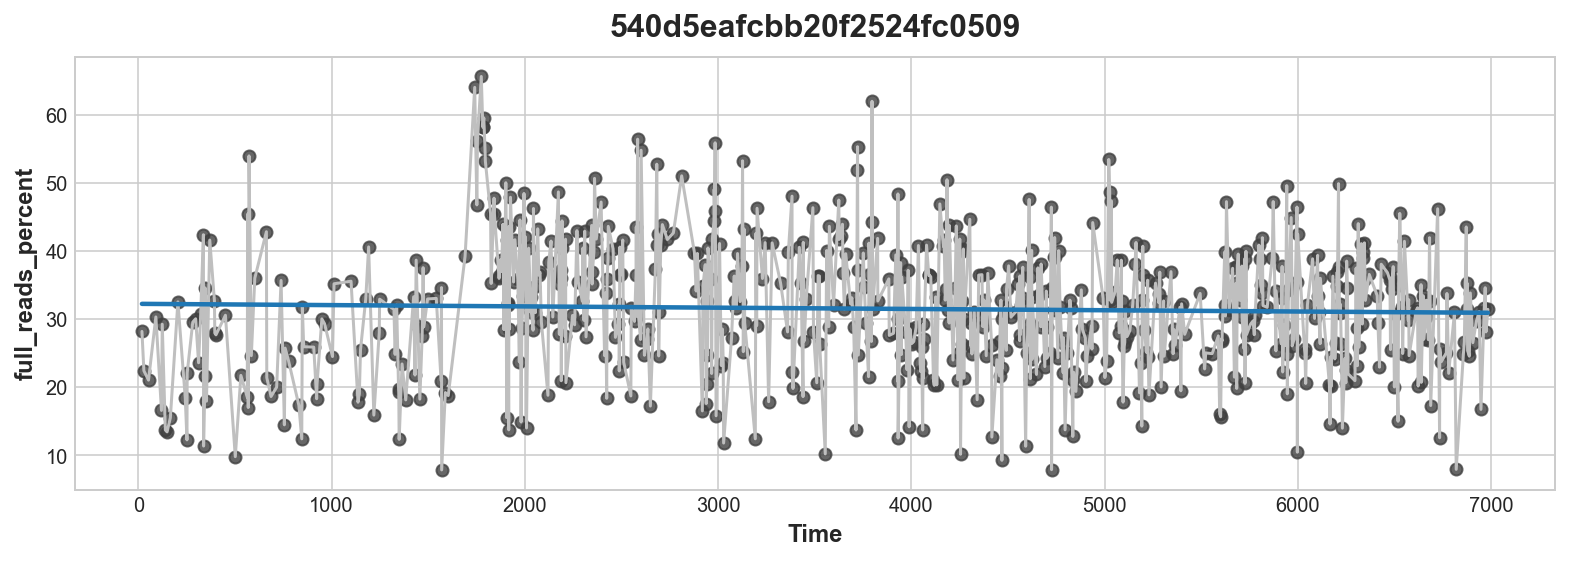

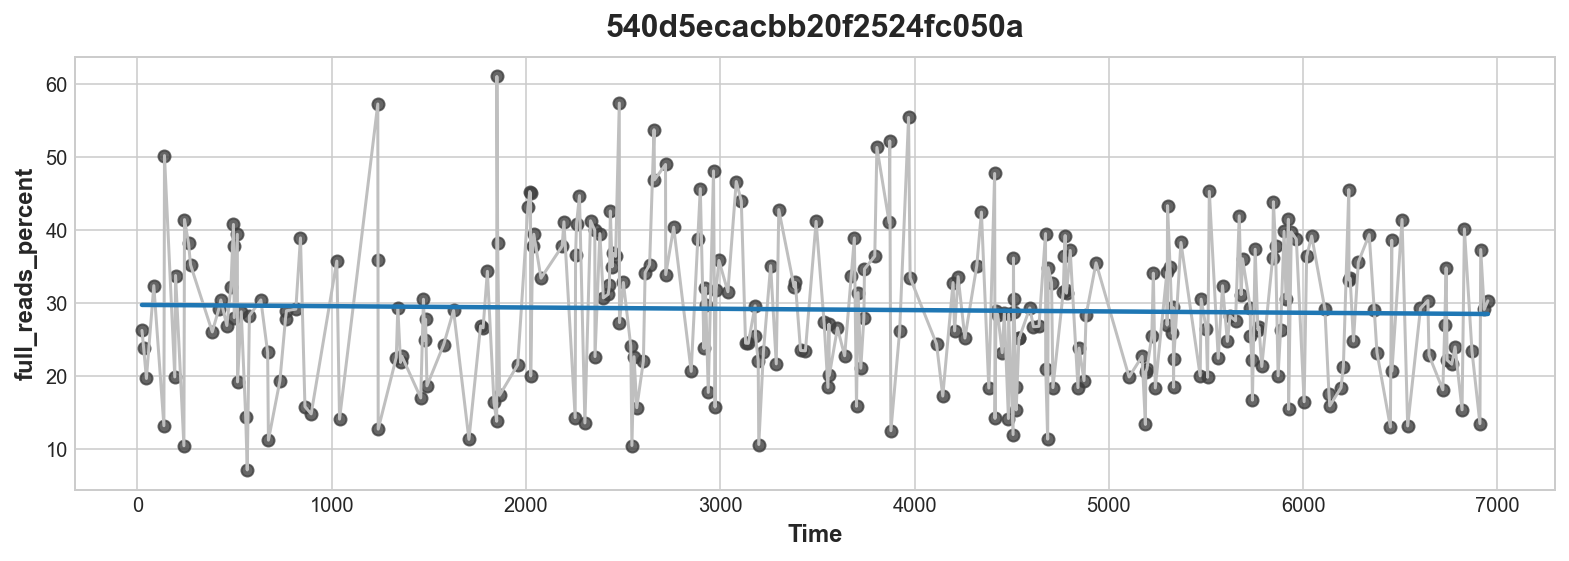

In [31]:
for col in ['views', 'depth', 'full_reads_percent']:
    for cat in cats:
        d = df[df['category'] == cat]
        show_timeline(d, col, cat)

In [35]:
df.to_csv(DATA_PATH/'time.csv')

In [123]:
df['Lag_1'] = df['views'].shift(1)
df_lag = df.reindex(columns=['views', 'Lag_1'])

df_lag.head()

,views,Lag_1
document_id,,
55c3984d9a79470f2c260465BKmAn_fHQruT38beqDIE_A,6238,NaN
5a8eb3149a7947e3e34bba2dbgzlzJ2GTQacZgtv4WEb1A,14558,6238.0
605321259a7947663a3b6ab2vgBnAMPBRIOYrUrK0JeEiQ,10160,14558.0
609d47119a794795c5f7617dh5z7vG_TQAu5Q7Nwp35LUw,52682,10160.0
5afd8e7f9a794772862de199oXkM3UjQQRK7NZTlmVi63A,4640,52682.0


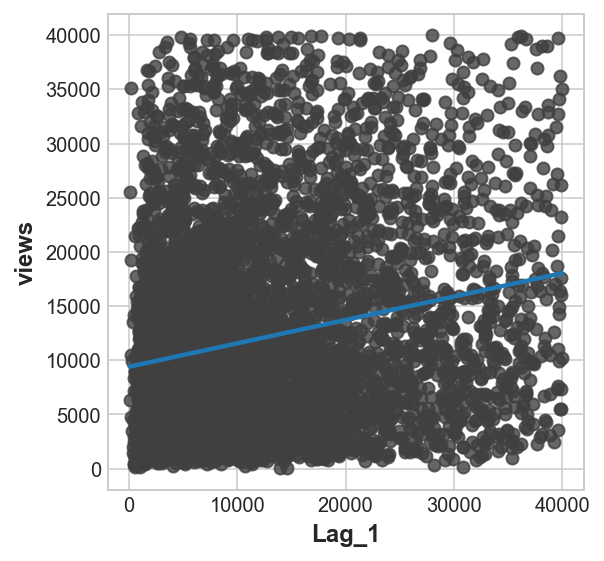

In [109]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='views', data=df_lag, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')

In [110]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'views']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

In [98]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

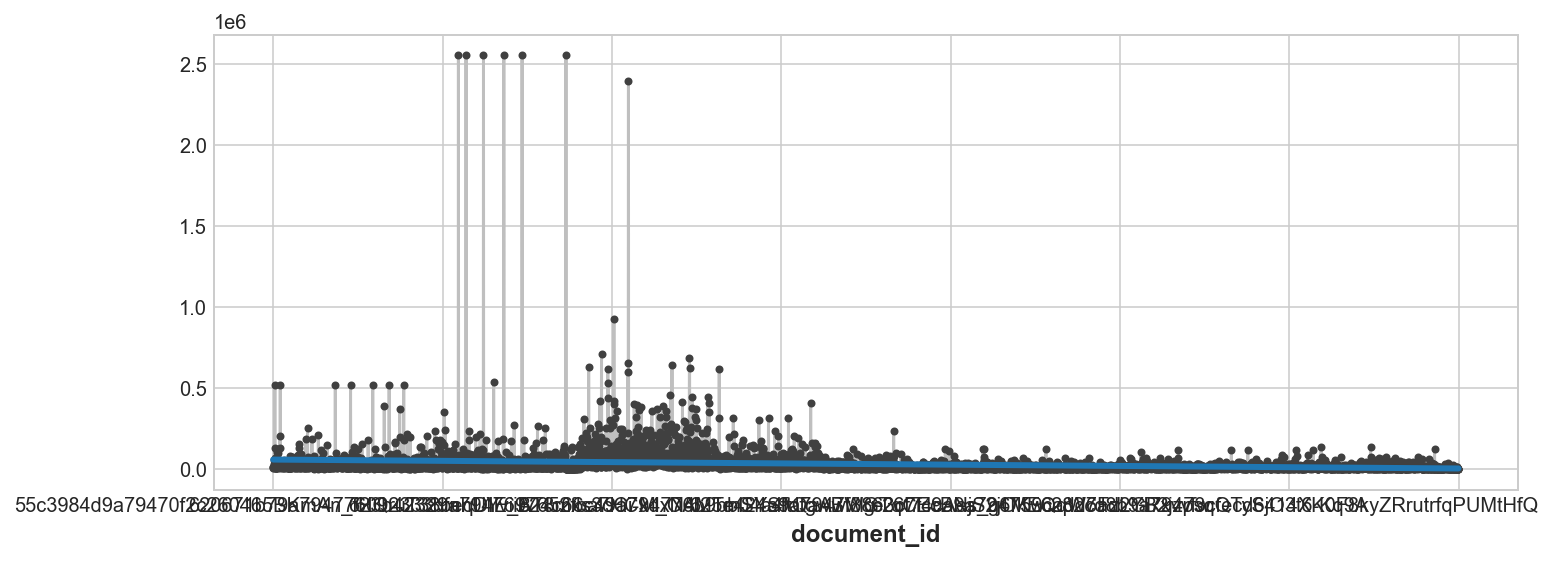

In [99]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)

In [100]:
r2_score(y, y_pred)

0.027554037682854804

## Preprocess data

In [3]:
def encode_dummies(df:DataFrame, col_name:str)->DataFrame:
    categories_df = pd.get_dummies(df[col_name], prefix=col_name)  # dummy_na = False -> no NaN found
    df = df.drop(col_name, axis=1)
    df = df.join(categories_df)
    return df

In [4]:
def encode_list_by_rate(df: DataFrame, col_name: str, rate_limit: float) -> DataFrame:
    def str_to_list(row: Series, col_name: str) -> Series:
        row[col_name] = ast.literal_eval(row[col_name])
        return row

    def get_col_encode_dict(df: DataFrame, col_name: str, rate_limit: float) -> Dict[str, int]:
        col_value_rates = df.explode(col_name)[col_name].value_counts(normalize=True)
        col_encode_dict = {}
        for index, (col_value, rate) in enumerate(col_value_rates.items()):
            if rate < rate_limit:
                break
            col_encode_dict[col_value] = index * 10

        return col_encode_dict

    def encode(row: Series, col_name: str, encode_dict: Dict[str, int], empty_code: int) -> Series:
        values = row[col_name]
        code = 0
        if len(values) == 0:
            code = empty_code
        else:
            for col_value, col_code in encode_dict.items():
                if col_value in values:
                    code += col_code

        row[col_name] = code
        return row

    df = df.apply(lambda row: str_to_list(row, col_name), axis=1)
    col_encode_dict = get_col_encode_dict(df, col_name, rate_limit)
    df = df.apply(lambda row: encode(row, col_name, col_encode_dict, -1), axis=1)
    return df

In [5]:
df_train = encode_dummies(df_train, 'category')

In [6]:
df_train = encode_list_by_rate(df_train, 'authors', 0.03)

In [7]:
df_train['day'] = pd.to_datetime(df_train['publish_date']).dt.strftime("%d").astype(int)
df_train['month'] = pd.to_datetime(df_train['publish_date']).dt.strftime("%m").astype(int)

In [8]:
df_train

,title,publish_date,session,authors,ctr,tags,views,depth,full_reads_percent,category_5409f11ce063da9c8b588a12,category_5409f11ce063da9c8b588a13,category_5409f11ce063da9c8b588a18,category_540d5eafcbb20f2524fc0509,category_540d5ecacbb20f2524fc050a,category_5433e5decbb20f277b20eca9,category_552e430f9a79475dd957f8b3,category_5e54e2089a7947f63a801742,category_5e54e22a9a7947f560081ea2,day,month
document_id,,,,,,,,,,,,,,,,,,,,
624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,IDE7mtH4RBqGn-8MXfGffQ,-1,1.580,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,35.850,0,0,1,0,0,0,0,0,0,4,4
620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,KtVJsteHStO5oditt3Uvzw,0,1.853,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,38.355,1,0,0,0,0,0,0,0,0,18,2
620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,Госсекретарь Швеции заявила о нежелании вступа...,2022-02-12 04:24:02,hk7puWJwSziw0m3sfTkKWA,-1,0.000,"['5430f451cbb20f73931ecd05', '5409f15de063daa0...",51151,1.185,36.424,1,0,0,0,0,0,0,0,0,12,2
6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,Песков назвал прагматичной выдачу лицензии Газ...,2022-04-22 13:24:55,7UKY2SSZTjCcjhwBzxw37w,-1,0.000,"['5409f297e063daa0f408b11c', '545caa9ecbb20f36...",3782,1.053,30.169,1,0,0,0,0,0,0,0,0,22,4
626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,В Хабаровске задержали главу филиала РАНХиГС п...,2022-04-25 10:42:23,wuMYES90REuV5YhrN75IXg,-1,0.000,"['5409f42ae063daa0f408b5d7', '585c20e19a79470e...",3065,1.063,34.617,0,0,0,0,0,1,0,0,0,25,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw,"Открытие Олимпиады, новые китайские контракты ...",2022-02-04 16:19:09,51RC_1i5QlGuv7B2FzwTjw,0,2.354,"['5c124ef99a79476e9d0352d3', '542c454ecbb20f60...",21738,1.188,28.448,0,0,0,0,0,1,0,0,0,4,2
628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ,Саудовская Аравия выразила надежду на соглашен...,2022-05-22 20:07:46,50tIkSGVSf2O8XQgk_uaHQ,0,4.112,"['543da39fcbb20f2fe7e8a83a', '59d3879e9a794726...",8377,1.056,38.045,0,0,0,1,0,0,0,0,0,22,5
6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug,Брюс Уиллис завершит актерскую карьеру из-за б...,2022-03-30 21:59:02,tKlqoxQYSmij0ZBrGzebug,-1,5.125,"['59e769a09a794784016dab04', '544539facbb20f34...",37004,1.176,50.757,0,0,0,0,0,1,0,0,0,30,3


In [14]:
score_dict = {"views":0.4, "depth":0.3,"full_reads_percent":0.3}

def calculate_score(y_true: Series, y_pred: Series, y_cols: List[str]) -> float:
    score = 0
    for i, col_name in enumerate(y_cols):
        if len(y_cols) > 1:
            y_pred_i = y_pred[:, i]
            y_true_i = y_true[col_name]
            score_coef = score_dict[col_name]
        else:
            y_pred_i = y_pred
            y_true_i = y_true[col_name].ravel()
            score_coef = 1
        score += score_coef * r2_score(y_true_i, y_pred_i)
    return score

In [10]:
X = df_train.drop(["views","depth","full_reads_percent","title","publish_date", "session", "tags"], axis = 1)
y = df_train[["views","depth","full_reads_percent"]]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
def train_score(y_cols:List[str], X_train, X_test, y_train, y_test):
    y_train = y_train[y_cols]
    y_test = y_test[y_cols]
    
    if y_train.shape[1]==1:
        y_train = y_train.values.ravel()
    
    estimator = RandomForestRegressor()
    
    param_grid = { 
            "n_estimators"      : [100, 500, 1000],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,5],
            "bootstrap": [True, False],
            }
    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)
    grid.fit(X_train, y_train)
    print(y_cols)
    print(grid.best_score_) 
    print(grid.best_params_)
    
    regr = RandomForestRegressor(**grid.best_params_)
    regr.fit(X_train, y_train)
    
    pred = regr.predict(X_test)
    score = calculate_score(y_test, pred, y_cols)
    print(score)
     
    col_name ='importance'
    importance_df = pd.DataFrame(regr.feature_importances_, columns=[col_name], index=regr.feature_names_in_).sort_values(by=col_name, ascending=False)
    display(importance_df)
    

In [13]:
for y_cols in ([["views"],["depth"],["full_reads_percent"], ["views","depth","full_reads_percent"]]):
    train_score(y_cols, X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy())

['views']
0.5264457954087332
{'bootstrap': False, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 1000}
0.6950308494713577


,importance
ctr,0.651411
month,0.125598
day,0.122506
authors,0.079786
category_540d5eafcbb20f2524fc0509,0.006472
category_5409f11ce063da9c8b588a12,0.006347
category_5433e5decbb20f277b20eca9,0.003206
category_5409f11ce063da9c8b588a13,0.002549
category_5409f11ce063da9c8b588a18,0.001084
category_540d5ecacbb20f2524fc050a,0.001022


C:\Users\evvEn\PycharmProjects\news\venv\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


['depth']
0.7376826906508092
{'bootstrap': True, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 1000}


C:\Users\evvEn\PycharmProjects\news\venv\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


0.7581953643692931


,importance
month,0.523695
ctr,0.176365
day,0.144721
authors,0.123647
category_5433e5decbb20f277b20eca9,0.014611
category_5409f11ce063da9c8b588a12,0.008434
category_540d5eafcbb20f2524fc0509,0.002755
category_5409f11ce063da9c8b588a13,0.002005
category_5409f11ce063da9c8b588a18,0.001956
category_540d5ecacbb20f2524fc050a,0.001776


['full_reads_percent']
0.2830614217676106
{'bootstrap': True, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 1000}
0.28884574713805


,importance
ctr,0.378485
day,0.233717
authors,0.232527
month,0.077573
category_5409f11ce063da9c8b588a18,0.020270
category_5433e5decbb20f277b20eca9,0.017567
category_5409f11ce063da9c8b588a12,0.015587
category_540d5ecacbb20f2524fc050a,0.010798
category_540d5eafcbb20f2524fc0509,0.007271
category_5409f11ce063da9c8b588a13,0.005761


['views', 'depth', 'full_reads_percent']
0.5120688478028648
{'bootstrap': False, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 500}


ValueError: y_true and y_pred have different number of output (1!=3)

In [15]:
for y_cols in ([["views","depth","full_reads_percent"]]):
    train_score(y_cols, X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy())

['views', 'depth', 'full_reads_percent']
0.5132190138940788
{'bootstrap': False, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 500}
0.5928562420973812


,importance
ctr,0.664685
day,0.121417
month,0.114622
authors,0.079157
category_5409f11ce063da9c8b588a12,0.007073
category_540d5eafcbb20f2524fc0509,0.005225
category_5433e5decbb20f277b20eca9,0.003127
category_5409f11ce063da9c8b588a13,0.002480
category_5409f11ce063da9c8b588a18,0.001106
category_540d5ecacbb20f2524fc050a,0.001090
